# Preview of data from Livox at Finse Flux Station
S. Filhol, Apr 2021

1. DEM preview
    - open, make little animation
    - Compare DEM to the first one
2. Cropped point cloud analysis
    - look at point cloud vertical distribution
    - derive precise snowdepth time series

Finseflux data on Grafana coresponding to the 2021-4-7 - 2021-4-13:
https://grafana.latice.eu/d/bFKh6Nrik/finse-flux?orgId=1&from=1617753600000&to=1618444799000

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import glob
import xarray as xr

from wsn_client import query

1. Load DEMs

In [2]:
ds = xr.open_mfdataset('../data/202104/*nc')
ds

In [16]:
fig, ax = plt.subplots(1,1)
(ds['min'].isel(x=slice(0,len(ds.x),5), y=190)-ds['min'].isel(x=slice(0,len(ds.x),5), y=190, time=0)).plot.line(ax=ax, x="time", alpha=.05, c='b', add_legend=False)
(ds['min'].isel(y=190).median(dim=['x'])-ds['min'].isel(y=190).median(dim=['x']).isel(time=0)).plot.line(c='k', ax=ax, label='Y=190 line meadian')
(ds['min'].median(dim=['x','y'])-ds['min'].median(dim=['x','y']).isel(time=0)).plot.line(c='r', ax=ax, label='Whole area Median')
plt.legend()
plt.ylim(-0.1,0.6)

(-0.1, 0.6)

In [21]:
fig, ax = plt.subplots(2,2)
ds['min'].isel(time=0).plot.imshow(vmin=-1, vmax=1, ax=ax[0,0])
(ds['min'].isel(time=50) - ds['min'].isel(time=0)).plot.imshow(vmin=-0.1, vmax=.3, ax=ax[0,1], cmap=plt.cm.Blues)
(ds['min'].sel(time='2021-04-09T17:00') - ds['min'].isel(time=0)).plot.imshow(vmin=-0.1, vmax=.3, ax=ax[1,0], cmap=plt.cm.Blues)
(ds['min'].isel(time=170) - ds['min'].isel(time=0)).plot.imshow(vmin=-0.1, vmax=.3, ax=ax[1,1], cmap=plt.cm.Blues)

Convert snow elevation maps to snow depth maps in reference of the first one

In [3]:
sd=(ds['min'] - ds['min'].isel(time=0))
sd

<xarray.DataArray 'min' (time: 196, y: 389, x: 1115)>
dask.array<sub, shape=(196, 389, 1115), dtype=float64, chunksize=(36, 389, 1115), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2021-04-07T09:00:00 ... 2021-04-13T06:00:00
  * x        (x) float64 -16.19 -16.17 -16.15 -16.13 ... 6.03 6.05 6.07 6.09
  * y        (y) float64 3.77 3.75 3.73 3.71 3.69 ... -3.93 -3.95 -3.97 -3.99

In [34]:
fig, ax = plt.subplots(1,3)
sd.isel(time=50).plot.imshow(vmin=-0.1, vmax=.3, ax=ax[0], cmap=plt.cm.Blues)
sd.isel(time=100).plot.imshow(vmin=-0.1, vmax=.3, ax=ax[1], cmap=plt.cm.Blues)
sd.isel(time=170).plot.imshow(vmin=-0.1, vmax=.3, ax=ax[2], cmap=plt.cm.Blues)



In [64]:
fig, ax = plt.subplots(1,1)
sd.isel(time=50).interpolate_na(dim='x', 
        method='linear', max_gap=0.4).plot.imshow(vmin=-0.1, vmax=.3, ax=ax, cmap=plt.cm.Blues)

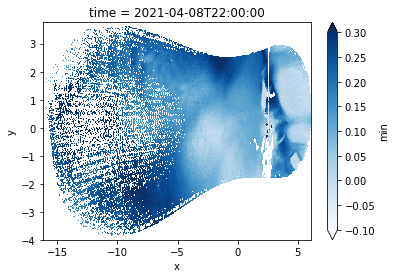

In [5]:
fig, ax = plt.subplots(1,1)
sd_int.isel(time=50).plot.imshow(vmin=-0.1, vmax=.3, ax=ax, cmap=plt.cm.Blues)

In [34]:
# attempt to use apply_ufunc to fill holes
from scipy import interpolate
def _interp2d(arr,x,y):
     print(x.shape)

     
     f = interpolate.interp2d(x,y,arr[:,:,1] , kind='cubic')
     print(f)
     return f(np.array(x),np.array(y))

ts = xr.apply_ufunc(_interp2d,sd,
     input_core_dims=[['time']], dask = 'allowed',kwargs={"x": sd.x, "y":sd.y})

(1115,)


In [39]:
msd = np.array(sd)
msd.shape

(196, 389, 1115)

(-0.1, 0.5)

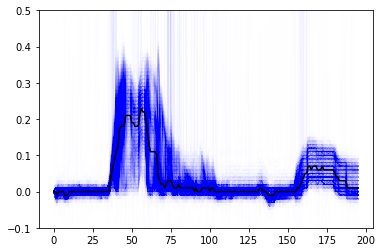

In [50]:
xs = range(0,msd.shape[2],10)
ys = range(0, msd.shape[1],10)
plt.figure()
for x in xs:
    for y in ys:
        plt.plot(msd[:,y,x], alpha=.005, c='b')
plt.plot(np.nanmedian(msd, axis=(1,2)), c='k')
plt.ylim(-0.1,.5)

In [59]:
start = pd.Timestamp(sd.time[0].values)
end = pd.Timestamp(sd.time[1].values)

df = query.query('clickhouse', serial=3668, table='finseflux_Biomet',limit=1000000,interval=60*5,
    interval_agg='mean', time__gte=start, time_lte=end)

In [60]:
df.columns

Index(['time', 'BEC_99_99_3_1_1', 'CS650PERIOD_99_99_3_1_1',
       'CS650VRATIO_99_99_3_1_1', 'FC1DRIFTmax_99_99_1_1_1',
       'FC1DRIFTmean_99_99_1_1_1', 'FC1DRIFTmin_99_99_1_1_1',
       'FC1DRIFTstd_99_99_1_1_1', 'FC1DRIFTsum_99_99_1_1_1',
       'FC1WSmax_16_99_1_1_1', 'FC1WSmean_16_99_1_1_1', 'FC1WSmin_16_99_1_1_1',
       'FC2DRIFTmax_99_99_1_1_1', 'FC2DRIFTmean_99_99_1_1_1',
       'FC2DRIFTmin_99_99_1_1_1', 'FC2DRIFTstd_99_99_1_1_1',
       'FC2DRIFTsum_99_99_1_1_1', 'FC2WSmax_16_99_1_1_1',
       'FC2WSmean_16_99_1_1_1', 'FC2WSmin_16_99_1_1_1', 'LWIN_6_14_1_1_1',
       'LWOUT_6_15_1_1_1', 'METNORA_99_99_1_1_1', 'METNORR_010_99_99_1_1_1',
       'METNORR_011_99_99_1_1_1', 'METNORR_99_99_1_1_1', 'METNOR_99_99_1_1_1',
       'METNOS_99_99_1_1_1', 'METNOmA_01_99_99_1_1_1', 'PA_4_2_1_1_1',
       'PA_4_2_2_1_1', 'PERMITTIVITY_99_99_3_1_1', 'RECORD', 'RH_19_3_1_1_1',
       'RH_19_3_1_2_1', 'SHF_6_37_1_1_1', 'SHF_6_37_2_1_1', 'SHF_99_37_1_1_1',
       'SHF_99_37_1_1_2', 'SHF_99_3

In [102]:
import datetime
start = datetime.datetime(2021,4,7,9)
end = datetime.datetime(2021,4,13,6)

df = query.query('clickhouse', serial=3668, table='finseflux_Biomet',limit=10000000,fields=['METNOS_99_99_1_1_1'], time__gte=start, time_lte=end)

In [98]:
df

time
2021-04-07 07:00:00      NaN
2021-04-07 07:01:00      NaN
2021-04-07 07:02:00      NaN
2021-04-07 07:03:00      NaN
2021-04-07 07:04:00    50.45
                       ...  
2021-04-13 08:55:00      NaN
2021-04-13 08:56:00    54.02
2021-04-13 08:57:00    54.05
2021-04-13 08:58:00    54.04
2021-04-13 08:59:00    53.92
Name: METNOS_99_99_1_1_1, Length: 8760, dtype: float64

In [112]:
df.METNOS_99_99_1_1_1.iloc[5]

50.45

In [124]:
df = df.loc[df.index<'2021-04-13 09:00:00']
df.loc[df.METNOS_99_99_1_1_1<25] = np.nan
df.METNOS_99_99_1_1_1.plot.scatter()


TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

In [116]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [118]:
fig, ax = plt.subplots(1,1)
(ds['min'].isel(x=slice(0,len(ds.x),5), y=190)-ds['min'].isel(x=slice(0,len(ds.x),5), y=190, time=0)).plot.line(ax=ax, x="time", alpha=.05, c='b', add_legend=False)
(ds['min'].isel(y=190).median(dim=['x'])-ds['min'].isel(y=190).median(dim=['x']).isel(time=0)).plot.line(c='k', ax=ax, label='Y=190 line meadian')
(ds['min'].median(dim=['x','y'])-ds['min'].median(dim=['x','y']).isel(time=0)).plot.line(c='k', linestyle='--', ax=ax, label='Whole area Median')
((df.METNOS_99_99_1_1_1 - df.METNOS_99_99_1_1_1.iloc[5])/100).plot(c='r', label='Weather Station', linewidth=2)
plt.legend()
plt.ylim(-0.1,0.6)


(-0.1, 0.6)

In [126]:
xs = range(0,msd.shape[2],10)
ys = range(0, msd.shape[1],10)
plt.figure()
for x in xs:
    for y in ys:
        plt.plot(sd.time,msd[:,y,x], alpha=.005, c='b')
plt.plot(sd.time,np.nanmedian(msd, axis=(1,2)), c='k', label='Median whole footprint', linewidth=2)
((df.METNOS_99_99_1_1_1 - df.METNOS_99_99_1_1_1.iloc[5])/100).plot(c='r', label='Weather Station', linewidth=2)
plt.legend(loc='upper right')
plt.ylabel('Snow depth [m]')
plt.ylim(-0.05,.5)
plt.grid(linestyle=':')

In [146]:
msd.shape
196/30

6.533333333333333

In [144]:
plt.figure()
ncurve=1
color = plt.cm.plasma(range(0,msd.shape[0], ncurve))
i=0
msd[msd[:,:,:]>1]=np.nan
for t in range(0,msd.shape[0], ncurve):
    plt.plot(sd.x, msd[t,150,:], color=color[i])
    i+=1
plt.ylim(-0.05,0.5)



(-0.05, 0.5)

Text(0.5, 1.0, 'Count - Apr 06, 2021')

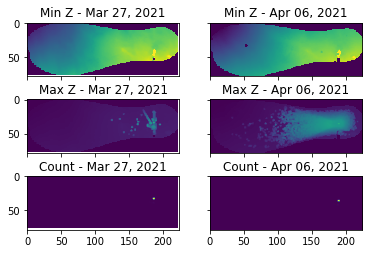

In [5]:
fig, axs = plt.subplots(3,2, sharex=True, sharey=True)
rast = rio.open(df.fname.iloc[0])
plot.show(rast.read(1),  vmin=-1, vmax=0.5, ax=axs[0,0])
plot.show(rast.read(2),  vmin=-1, vmax=16, ax=axs[1,0])
plot.show(rast.read(5), ax=axs[2,0])

axs[0,0].set_title('Min Z - ' + df.tst.iloc[0].strftime('%b %d, %Y'))
axs[1,0].set_title('Max Z - ' + df.tst.iloc[0].strftime('%b %d, %Y'))
axs[2,0].set_title('Count - ' + df.tst.iloc[0].strftime('%b %d, %Y'))
rast = rio.open(df.fname.iloc[-1])
plot.show(rast.read(1),  vmin=-1, vmax=0.5, ax=axs[0,1])
plot.show(rast.read(2),  vmin=-1, vmax=16, ax=axs[1,1])
plot.show(rast.read(5), ax=axs[2,1])

axs[0,1].set_title('Min Z - ' + df.tst.iloc[-1].strftime('%b %d, %Y'))
axs[1,1].set_title('Max Z - ' + df.tst.iloc[-1].strftime('%b %d, %Y'))
axs[2,1].set_title('Count - ' + df.tst.iloc[-1].strftime('%b %d, %Y'))

In [6]:
rast_ref = rio.open(df.fname.iloc[0])
rast_t = rio.open(df.fname.iloc[-1])
plt.figure()
plt.imshow(rast_t.read(1)[:,1:]-rast_ref.read(1))
plt.colorbar()
plt.title('Snow depth change (m) \n' + 
          df.tst.iloc[0].strftime('%b %d') + 
         ' - ' +
          df.tst.iloc[-1].strftime('%b %d, %Y'))

ValueError: operands could not be broadcast together with shapes (79,223) (77,222) 

<Figure size 432x288 with 0 Axes>

In [100]:
rast_extent(df.fname.iloc[0])

[-15.71, 6.289999999999999, -3.9000000000000004, 4.1]

In [101]:
rast_extent(df.fname.iloc[-1])

[-16.15, 7.850000000000001, -3.92, 4.08]

2. Point Clouds

In [7]:
from laspy import file
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

In [16]:
path_to_data = '../data/LIVOXFinse/Event_1_4-5/'
las_list = glob.glob(path_to_data+'*cropped.las')
las_list.sort()

In [17]:
las_list.__len__()

628

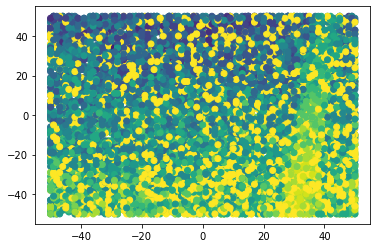

In [18]:
las = file.File(las_list[-10])
plt.figure()
plt.scatter(las.get_x(), las.get_y(), c=las.get_z(), vmin=15, vmax=30)
#plt.ylim([0,100])

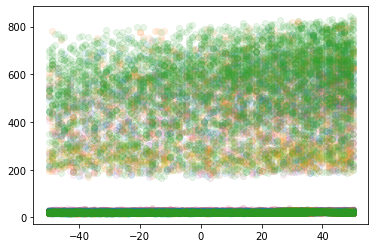

In [21]:

plt.figure()
for i in range(0, 628, 50):
    plt.scatter(file.File(las_list[i]).get_x(), file.File(las_list[i]).get_z(), alpha=.1)

In [32]:
%matplotlib

Using matplotlib backend: Qt5Agg


### Ideas to correlate point cloud noise to precipitation

Precip from point clouds
- look at absolute number of points per scan
- look at centroid of point per scan, with standard deviation
- look at mean/meadian distance in between points
- 

Create a dataframe to extract stats from the point cloud

Download data from wsn database:
    - geonor
    - flowcapt 1 and 2
    - RH
    


In [51]:
dg = pd.DataFrame()
dg['fname'] = las_list
dg['tst'] = pd.to_datetime(dg.fname.apply(lambda x: x.split('/')[-1][:-11]), format='%Y.%m.%dT%H-%M-%S')
dg = dg.set_index(dg.tst)

In [57]:
def extract_cloud_precip(fname):
    mylas = file.File(fname)
    df = pd.DataFrame()
    df['x'] = mylas.get_x()[mylas.get_z()>100]
    df['y'] = mylas.get_y()[mylas.get_z()>100]
    df['z'] = mylas.get_z()[mylas.get_z()>100]
    return df
 
dg['p_count'] = dg.fname.apply(lambda x: extract_cloud_precip(x).shape[0])
dg['z_mean'] = dg.fname.apply(lambda x: extract_cloud_precip(x).z.mean())
dg['z_median'] = dg.fname.apply(lambda x: extract_cloud_precip(x).z.median())
dg['z_std'] = dg.fname.apply(lambda x: extract_cloud_precip(x).z.std())
dg['x_mean'] = dg.fname.apply(lambda x: extract_cloud_precip(x).x.mean())
dg['y_mean'] = dg.fname.apply(lambda x: extract_cloud_precip(x).y.mean())
dg['x_median'] = dg.fname.apply(lambda x: extract_cloud_precip(x).x.median())
dg['y_median'] = dg.fname.apply(lambda x: extract_cloud_precip(x).y.median())

In [78]:
%matplotlib
fig, axs = plt.subplots(2,1, sharex=True)
dg.z_mean.plot(ax=axs[0])
axs[0].fill_between(dg.tst, (dg.z_mean-dg.z_std).values, (dg.z_mean+dg.z_std).values, alpha=.2)

dg.p_count.plot(ax=axs[1])#, logy=True)
(dg.p_count*0+1000).plot(ax=axs[1], c='k')

Using matplotlib backend: Qt5Agg


<AxesSubplot:xlabel='tst'>

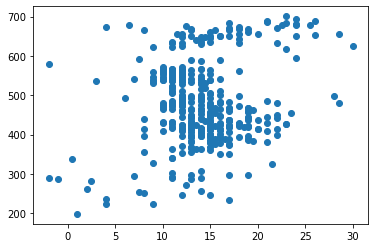

In [71]:
plt.scatter(dg.x_median.loc[dg.p_count>100], dg.z_median.loc[dg.p_count>100])

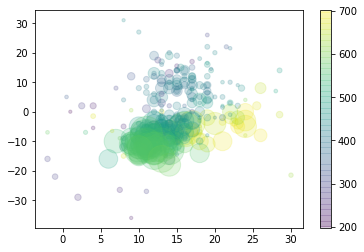

In [77]:
plt.scatter(dg.x_median.loc[dg.p_count>100], dg.y_median.loc[dg.p_count>100], c=dg.z_median.loc[dg.p_count>100], alpha=.2, s=dg.p_count.loc[dg.p_count>100]/10)
plt.colorbar()